<a href="https://colab.research.google.com/github/GuiUzeda/ML-e-Tutoriais-Relacionados/blob/master/TFRecods_datasets_dentro_do_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFRecods: *datasets* dentro do *Tensorflow*







## 1 Introdução:

*TFRecords* é um tipo de dados binário criado especiamente para ser utilizado em pipelines de dados no Tensorflow. Principalmente quando se está trabalhando com grandes séries de dados, usar um formato de dados binário traz uma série de melhorias de performance no treinamento do modelo. Esse modelo descomplica o gerenciamento de *datasets* e pode diminuir os tempos de treinamento.

Os dados utilizados aqui podem ser encontrados em: https://pjreddie.com/projects/cifar-10-dataset-mirror/.
Para os testes em TPU o [Google Colab](https://colab.research.google.com) pode ser utilizado sem perdas.

----
\*Esse notenook tem dependência entre as células, ou seja, células mais ao final fazem uso de classes, funções, variáveis e dados criadas nas células anterios

## 2 Objetivo

Esse *Notebook* tem por objetivo demonstrar a tulização de *TFRecords* para salvar, ler e manipular datasets. Adicionalmente, como conteúdo complementar, este material faz uma breve introduçao sobre como incorporar *data augmentation* em um *dataset* do *Tensorflow*

## 3 TFRecords

[*TFRecords*](https://www.tensorflow.org/api_guides/python/python_io) é um tipo de dados binário criado especiamente para ser utilizado em *pipelines* de dados no *Tensorflow*. Principalmente quando se está trabalhando com grandes séries de dados, usar um formato de dados binário traz uma série de melhorias de performance no treinamento do modelo. Isso por que dados binarizados ocupam menos espaço e demoram menos tempo para serem lidos do disco (especialmente dos discos rígidos). Além disso, a otimização do modelo *TFRecodrs* no *Tensorflow* permite trabalhar com dados de forma mais eficiente e com uma boa integração às APIs de alto nível como os *Estimators*.

Ao invés de carregar os dados para a memória Python em formato Pandas ou Numpy para depois serem transformados em Tensores dentro do Grafo, o *TFRecord* permite que os dados sejam carregados para dentro da seção do *Tensorflow* sem intermediário. Isso é importante especialmente quando se tem uma série de dados muito grande ou dividia em mais de um arquivo, uma vez que apenas as partes necessárias para cada etapa de treinamento (*batches*) são carregadas do disco e processadas. Entretanto, a grande inconveniência desse modelo é que é necessário transformar todos os dados antes de qualquer processamento.

### 3.1 Estrutura do TFRecord

*TFRecord*  armazena os dados em *strings* binárias, isso significa que é preciso especificar qual a estrutura de dados. Para isso, existem dois componentes no *Tensorflow*: [tf.train.Example](https://www.tensorflow.org/api_docs/python/tf/train/Example) e [tf.train.SequenceExample](https://www.tensorflow.org/api_docs/python/tf/train/SequenceExample), sendo que a diferença entre eles é que o primeiro é uma lista de propriedades de cada exemplo e o segundo é uma lista de listas de propriedades de cada exemplo. Cada um dos dados de exemplos precisam ser armazedos em um desses dois formatos, serializados e gravados no disco utilizado [tf.python_io.TFRecordWriter ](https://www.tensorflow.org/api_docs/python/tf/python_io/TFRecordWriter). Vale lembrar que `tf.train.Example` não é uma classe, mas um protocolo de *buffer*. Um protocolo de *Buffer* é um metodo desenvolvido pelo Google para serializar estruturas de dados de forma eficiente.



### 3.2 Convertendo os dados em TFRecord

Nesta seção os dados são convertidos em TFRecord utilizando o método `tf.train.Example`. Os dados que utilizaremos são images da base de dados **CIFAR-10**. Basicamente são imagens quadrades (32X32) com 10 classes diferentes e mais informações sobre o dataset podem ser encontradas [aqui](https://www.cs.toronto.edu/~kriz/cifar.html). As imagens estão normalizadas e são representadas como tipo *float*. Primeiramente é necessário fazer o download das images e descompactar os arquivos:

In [2]:
# Download dos arquivos
!wget http://pjreddie.com/media/files/cifar.tgz
  
# Descompactar os arquivos na pasta Cifar
!tar xzf cifar.tgz
        
# Criar um diretório para os novos TFRecords
!mkdir cifar_tfrecords

--2019-01-16 00:31:55--  http://pjreddie.com/media/files/cifar.tgz
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/cifar.tgz [following]
--2019-01-16 00:32:00--  https://pjreddie.com/media/files/cifar.tgz
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168584360 (161M) [application/octet-stream]
Saving to: ‘cifar.tgz’

cifar.tgz           100%[===================>] 160.77M  64.0MB/s    in 2.5s    

2019-01-16 00:32:03 (64.0 MB/s) - ‘cifar.tgz’ saved [168584360/168584360]



Os dados que foram descompactados estão organizados e divididos em duas pastas: *train* e *test*. Há também um arquivo com 10 classes que pode ser considerado como um "vocabulário" de classificão. É possível ver as classes com o comando:

In [3]:
!cat cifar/labels.txt

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


Antes de começar a mexer com os dados é necessário importar as bibliotecas necessárias

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Os dados do Cifar-10 adiquiridos anteriormente já estão bem divididos entre treino e teste. Se este não fosse o caso aqui seria uma boa hora para dividí-los e garantir que os *sets* de treino e teste não se misturem. É possível, também, dividir os dados dentro da classe *Dataset* do *Tensorflow* no momento da leitura do *dataset*.

O código a baixo está definindo qual o caminho absoluto da pasta dos dados e armazenando na variável `cifar_path`. Apesar de ser possível usar apenas caminhos relativos para para referenciar o local das imagens é mais aconselhável fazê-lo com os caminhos absolutos. 

O *dataset* que está sendo trabalhado aqui é composto por imagens de 32X32 píxeles armazenadas em duas pastas: *train* e *test*. O nome de cada imagem é composto por um *id* e pela classe de classificação no padrão: `id_classe.png`. Assim, uma lista das imagens de treino e teste é armazenada em um dicionário para facilitar a consulta posterior.

Como já mencionado, o arquivo `labels.txt` estão registradas as 10 classes possíveis para as imagens. Nota-se que, para aplicação de redes neurais, não é possível utilizar as classes pelos seus nomes, por isso uma codificação será feita. Para facilitar tal processo, cria-se um `tuple` com os nomes das classes que servirá de referência para essa codificação.



In [0]:
# define o caminho absoluto para a pasta cifar
cifar_path = os.path.join(os.getcwd(), "cifar")

# Lê a lista de imagens e coloca em um dicinário
data_dict = { 
    "train": os.listdir(os.path.join(cifar_path, "train")),
    "test" : os.listdir(os.path.join(cifar_path, "test"))
}

# Lê os arquivos com as classes e coloca um um taple chamado labels
with open(os.path.join(cifar_path, "labels.txt"), "r") as file:

  	labels_tuple = tuple( file.read().splitlines() )


Como já dito anteriormente, o *TFRecord* armazena os dados como um sequencia binária, ou seja, é preciso determinar qual a estrutura dos dados antes de escrevê-los no arquivo para que possam ser recuperados da forma correta. Nesse caso vamos usar o protocolo de buffer  `tf.train.Example` (lembrando que  ` tf.train.Example` não é uma classe comum do python) e `tf.python_io.TFRecordWriter`para escrever os dados no disco. 

Neste caso temos apenas duas *features*: a image e a classe. Na realidade a classe não é uma *feature*, mas para facilitar a leitura dos dados e garantir que os pares de dados sem lidos de forma correta vamos encapsular as classes dentro de uma *feature*. 

Um ` tf.train.Example` é composto por várias *features* definidas por `tf.train.Features`, que por sua vez é um dicionário de mais de uma `tf.train.Feature`. Por fim, `tf.train.Feature` é composto por `tf.train.BytesList`, `tf.train.FloatList` ou `tf.train.Int64List`, que determinam qual o tipo dos dados dentro de cada *feature*. Por exemplo:

```
image_byteslist = tf.train.BytesList(value=[iamge_bytes])
label_intlist = tf.train.Int64List(value=[int_label])

image_feture = tf.train.Feature(bytes_list=image_byteslist)
label_feature = tf.train.Feature(int64_list=label_intlist)

dict_feature = {
      "img" : image_feture,
      "label" : label_feature
      }
features = tf.train.Features(feature = dict_feature)
example = tf.train.Example(features = features)
```

No caso das imagens, serão lidos e salvos no *TFRecord* os bytes das imagens. Já as classes serão codificadas conforme o tuple `label` seguindo a seguinte regra:

>Nome da Classe | Código
>--- | --- 
>airplane | 0
>automobile| 1
>bird| 2
>cat| 3
>deer| 4
>dog| 5
>frog| 6
>horse|7
>ship| 8
>truck| 9


In [0]:
# As classes vão ser posteriormente codificadas em um array por isso devem se manter
# na mesma posição de o arquivo labels.txt

# Loop nas listas do data_dict
for key, values in data_dict.items():
  
  #Cria um writer capaz de escrever os arquivos .tfrecord
  with tf.python_io.TFRecordWriter(os.path.join('cifar_tfrecords',key+'.tfrecord' )) as writer:
    
    # Para cada nome de arquivo é preciso ler os bytes da imagem e
    # codificar a classe com base no nome da imagem 
    
    for img_name in values:
      # Separa o nome da classe do nome da imagem
      img_label_name = img_name[:-4].split("_")[-1]
      # Pega o código da classe confrome o index do tuple labels
      img_label = labels_tuple.index(img_label_name)

      # Cria um protocolo Feature com o valor inteiro da classe
      label_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[img_label]))
      
      # Lê os bytes da imagem
      with open(os.path.join(cifar_path,key,img_name), 'rb') as file:        
        img_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[file.read()]))
      
      # Cria um exemplo com as features img e label e salva no .tfrecord
      feature = {'label': label_feature,
                 'img': img_feature}
      example = tf.train.Example(features=tf.train.Features(feature=feature))
      writer.write(example.SerializeToString())

### 3.3 Lendo TFRecord

Para ler os arquivos os seguintes passos são necessários:



1.   **Criar uma lista com os nomes de arquivos:** Podem ser lidos mais de um arquivo por vez, mas no caso aqui utilizado a lista vai apenas conter os dados de treino `["cifar_tfrecords/train.tfrecord"]`;
2.   **Criar um *Dataset* com os arquivos *TFRecord*:** Para isso, utiliza-se `tf.data.TFRecordDataset`
3. **Criar uma função para decodificar as imagens e as classes:** Essa função decodifica o um exemplo restaurando as features
4. **Decodificar cada exemplo do *dataset*:** Usadndo `Dataset.map` aplica-se a função criada no item anterior para cada um dos dados do *dataset*
5. **Construir um *Iterator*:** com `make_one_shot_iterator()` podemos criar um *Iterator* que vai ser responsável para pegar o próximo item do *dataset* e colocar em um tensor
6. **Abrir um seção do *Tensorflow*:** Dentro da seção podemos avaliar os tensores os exemplos do *dataset*
7. **Ler um exemplo do *dataset*:** Usando `get_next()` criamos tensores com os dados de um exemplo
8. **Avaliar os tensores:** Com `sess.run()` avaliasse os tensores para plotar a imagem e mostrar a classe






Aqui uma das vantagens do *TFRecords* fica clara. A leitura dos dados ocorre de forma transprarente, sem a necessidade de carregar as imagens para a memória python em formato numpy. Ao contrário, os dados são alocados diretamente em tensores com a função `parser`

A função aqui denominada `parser` é responsável por decodificar um exemplo do arquivo *TFRecord* da forma correta. Um dicionário vai guiar cada uma das features e designar um forma (*shape*), um tipo e um padrão para os casos de ausência de dados. Isso pode ser feito utilizando `tf.FixedLenFeature` ou  `tf.VarLenFeature`. Vale lembrar que as chaves do dicionário devem ter o mesmo nome dos das *featuatures* que salvamos na seção anterior. De froma simples, `tf.parse_single_example` pode ser utilizado agora para ler o exemplo serealizado. Adicionalemente deve-se usar `tf.image.decode_jpeg` para decodificar o texto de bytes em um tensor numérico e usar `set_shape` para definir a forma da imagem. Quanto as classes, apenas uma `tf.cast` é necessário para deira no formato correto

In [0]:
def parser(serialized_example):
  """ 
  Função para decodificar um exemplo do TFRecord de acordo com 
  o tipo de cada uma das features
  """
  
  # Cria um dict que dita o shape, type e dafault de cada feature
  features_dict = {
          'img': tf.FixedLenFeature([], tf.string),
          'label': tf.FixedLenFeature([], tf.int64),
      }
  
  # Deserealiza o exemplo
  features = tf.parse_single_example(
      serialized_example,
      features=features_dict)
  
  # Decodifica a imagem de bytes para int8 e determina o tamanho para 32X32X3
  image  = tf.image.decode_jpeg(features['img'], channels=3)
  image.set_shape([32 , 32,3])

  # Assegura que as labels estão no tipo int32
  label = tf.cast(features['label'], tf.int32)
  
  return image, label



A função `map` funciona de forma muito parecida da função `map` do python, a diferença é que aqui ao invés de ser processada no *runtime* python o processamento acontece dentro da seção do *Tensorflow*. 

O *Iterator* nada mais é do que uma fila onde um ou mais exemplos são tirados por vez. É possível definir *iterators* (re)inicializáveis e também salvar o estado de um *iterator*. Para maiores informações verificar a [documentação](https://www.tensorflow.org/api_guides/python/reading_data)

A saída da célula a baixo é um exmplo de imagem com sua respectiva classe. Aqui foi usada a *tuple* criada anteriormente para decodificar também a classe para texto

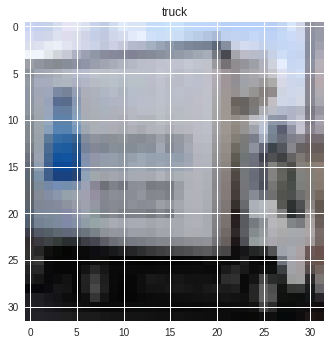

In [8]:
# Lista de arquivos TFRecord a serem lidos, podem ser passados N arquivos
train_filenames = ["cifar_tfrecords/train.tfrecord"]

# Cria o dataset a partir do TFRecord e mapeia os exemplos com a função parser
dataset = tf.data.TFRecordDataset(train_filenames)
dataset = dataset.map(parser, num_parallel_calls=1)

# Cria um Iterator
iterator = dataset.make_one_shot_iterator()
with tf.Session() as sess:
  features, labels = iterator.get_next()
  image, label = sess.run([features, labels])
  plt.imshow(image)
  plt.title(labels_tuple[label])

## 4 Manipulando *datasets* e *data augmentation*

Uma vez que o *dataset* está criado dentro do grafo do *Tensorflow* é possível aplicar algumas manipulações como embaralhar, dividir e agrupar *batches*. A classe [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) tem algumas funções muito úteis para manipular dados. Uma lista completa de funções pode ser encontrada na documentação, mas as funções mais usadas são as seguintes:

>Função | Descrição | Exemplo
>--- | --- | ---
>apply | Aplica uma transformação no *dataset* | `apply(func_transfor)`
>batch | Combina elementos consecutivos do *dataset* em um *batch* | `batch(tamanho_batch, drop_remainder=False)`
>cache | Coloca os elementos de um *dataset* em *cache* | `cache(filename='arquivo_cache')`
>concatenate | Cria um novo *dataset* concatenando dois *datasets* | `concatenate(dataset)`
>flat_map | Mapeia uma função em todo o *dataset* e "achata" o resultado | `flat_map(map_func)`
>map | Mapeia uma função em todo o *dataset* | `map(map_func,num_parallel_calls=None)`
>reduce | Agrega o *dataset* em um único elemento a partir de um função | `reduce(initial_state,reduce_func)`
>repeat | Repete o *dataset* n vezes |`repeat(count=None)`
>shuffle | Embaralha o *dataset* aleatoreamente | `shuffle(tamanho_buffer,seed=None,reshuffle_each_iteration=None)`
>skip| Cria um *dataset* que deixa de fora n elementos do *dataset* original | `skip(count)`
> take | Cria um *dataset* com no máximo n elementos do *dataset* original | `take(count)`

>**Importante:** para efeitos de performance é recomendável evitar shuffle após batch

No caso de imagens é possível ainda é possível fazer *data augmentation* ao ler as images para obter um grau de generalização melhor do modelo. Tal procedimento pode ser feito de forma muito eficiente dentro do *Tensorflow* utilizando o módulo [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) ao invés de se pré-processar ou processar os exemplos durante o treino. Tal abordagem poupa de forma significativa espaço em disco e memória e possibilita maior velocidade de treino, uma vez que o *Tensorflow* apenas carrega para a memória os dados necessários para cada *step*.

A baixo um exemplo de como algumas dessas funções entrariam no *pipe line* criado acima. Nota-se que a manipulação de imagens é feita diretamente dentro da função `parser` que, por sua vez, é mapeada para cada elemento do *dataset*. A saída das células a baixo deve mudar cada vez que é executada devido à função `shuffle`.



In [0]:
def data_augmentation(iamge):
  """
  Uma função ilustrativa de data augmentation apenas para mostrar como aplicar
  esse tipo de procedimento em um dataset do Tensorflow
  """
  
  image = tf.image.random_brightness(image,.2)
  image = tf.image.random_flip_left_right(image)
  random_crop_factor = tf.random.uniform([1],0,.2)
  image = tf.image.random_crop(image, [25,25,3])
  return image
  
  
def parser(serialized_example):
  """ 
  Função para decodificar um exemplo do TFRecord de acordo com 
  o tipo de cada uma das features com data augmentation para as imagens
  """
  
  # Cria um dict que dita o shape, type e dafault de cada feature
  features_dict = {
          'img': tf.FixedLenFeature([], tf.string),
          'label': tf.FixedLenFeature([], tf.int64),
      }
  
  # Deserealiza o exemplo
  features = tf.parse_single_example(
      serialized_example,
      features=features_dict)
  
  # Decodifica a imagem de bytes para int8 e determina o tamanho para 32X32X3
  image  = tf.image.decode_jpeg(features['img'], channels=3)
  image.set_shape([32 , 32,3])
  
  image = data_augmentation(image)

  # Assegura que as labels estão no tipo int32
  label = tf.cast(features['label'], tf.int32)
  
  return image, label


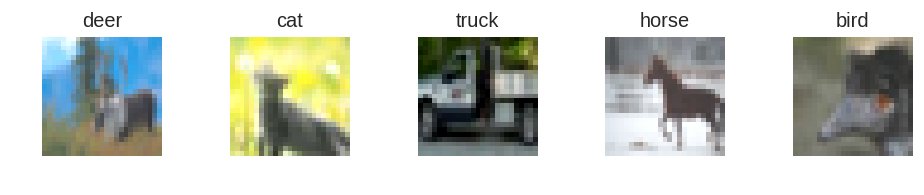

In [88]:
# Lista de arquivos TFRecord a serem lidos, podem ser passados N arquivos
train_filenames = ["cifar_tfrecords/train.tfrecord"]
# Define o tamanho do batch
batch_size = 5
# Cria o dataset a partir do TFRecord
dataset = tf.data.TFRecordDataset(train_filenames)

# Embaralha o dataset com um buffer 2x o tamanho do batch
dataset = dataset.shuffle(batch_size*2)

# Mapeia os exemplos com a função parser
dataset = dataset.map(parser, num_parallel_calls=1)

# Retepe o dataset 5 vezes (apenas para efeito ilustrativo)
dataset = dataset.repeat(5) 

# Cria os batches
dataset = dataset.batch(batch_size)

# Cria o gráfico para plotar as imagens
n_cols = min(10, batch_size)
n_rows = int(batch_size/n_cols) + min(1, batch_size%n_cols)
fig, ax = plt.subplots(n_rows, n_cols)
fig.tight_layout()
fig.dpi=120
ax = ax.ravel()

# Cria um Iterator
iterator = dataset.make_one_shot_iterator()

# Inicia uma seção do Tensorflow
with tf.Session() as sess:
  
  # Carrega o próximo batch de acordo com o iterator
  features, labels = iterator.get_next()
  # Avalia efetivamente as imagens e labels
  images, labels = sess.run([features, labels])
  
  # Plota as imagens 
  for n,il in enumerate(zip(images, labels)):
    image=il[0]
    label=il[1]
    ax[n].set_axis_off()
    ax[n].imshow(image)
    ax[n].set_title(labels_tuple[label])


## 5 Conclusão

*TfRecords* é um formato de arquivo que pode auxiliar de forma significativa o treino de uma rede neural, pois os dados são lidos de forma gradual e conforme a necessidade. Entretanto o lado negativo é a necessidade de conversão dos arquivos originais que, apesar de ser simples e ocorrer apenas uma vez, pode demorar algum tempo. Juntamente com *TFRecord* utilizar *datasets* dentro do *Tensorflow* facilita a manipulação de dados de forma mais automatizada e intuitiva. Além disso, torna-se mais facil de trabalhar com *data augmentation* durante o treino, sem a necessidade de pré processar todo o *dataset*.

Esse material não extingue o assunto, mas ao contrário, contém uma introdução do conteúdo abordado. Vale lembrar que esse é um conteúdo aberto e comunitário, contribuições, corressões e sujestões são sempre bem-vindas!